<a href="https://colab.research.google.com/github/vcskaushik1/Sneeze-Detection/blob/master/Advanced_DL_Project_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import cv2
import os
import math
import random
import json
#%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras 
from google.colab import drive
drive.mount('/content/drive/')
#tf.keras.utils.p

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, ZeroPadding3D, BatchNormalization, Activation, Attention
from tensorflow.keras.layers import LSTM, TimeDistributed,Conv2D, MaxPooling3D, Conv3D,MaxPooling2D
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.optimizers import Adam, RMSprop
#from tensorflow.keras.layers.wrappers import TimeDistributed
#from tensorflow.keras.layers.convolutional import (Conv2D, MaxPooling3D, Conv3D,MaxPooling2D)
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from skimage.io import imread, imread_collection, concatenate_images, ImageCollection
from tensorflow.keras.utils import Sequence
#from keras import backend as K

In [0]:
!cp -r drive/"My Drive"/"Adv DL project"/"PGM" ADV_FILES

In [0]:
!unzip drive/"My Drive"/"Adv DL project"/frames.zip -d ADV_FILES/

Streaming output truncated to the last 5000 lines.
  inflating: ADV_FILES/frames/S018_M_SNEE_WLK_RGT_frames/frame75.jpg  
  inflating: ADV_FILES/frames/S018_M_SNEE_WLK_RGT_frames/frame20.jpg  
  inflating: ADV_FILES/frames/S018_M_SNEE_WLK_RGT_frames/frame48.jpg  
  inflating: ADV_FILES/frames/S018_M_SNEE_WLK_RGT_frames/frame58.jpg  
  inflating: ADV_FILES/frames/S018_M_SNEE_WLK_RGT_frames/frame8.jpg  
  inflating: ADV_FILES/frames/S018_M_SNEE_WLK_RGT_frames/frame80.jpg  
  inflating: ADV_FILES/frames/S018_M_SNEE_WLK_RGT_frames/frame51.jpg  
  inflating: ADV_FILES/frames/S018_M_SNEE_WLK_RGT_frames/frame5.jpg  
  inflating: ADV_FILES/frames/S018_M_SNEE_WLK_RGT_frames/frame73.jpg  
  inflating: ADV_FILES/frames/S018_M_SNEE_WLK_RGT_frames/frame53.jpg  
  inflating: ADV_FILES/frames/S018_M_SNEE_WLK_RGT_frames/frame16.jpg  
  inflating: ADV_FILES/frames/S018_M_SNEE_WLK_RGT_frames/frame3.jpg  
  inflating: ADV_FILES/frames/S018_M_SNEE_WLK_RGT_frames/frame10.jpg  
  inflating: ADV_FILES/frames

In [0]:
!unzip ADV_FILES/Test_set.zip -d ADV_FILES/"Adv DL project"
!unzip ADV_FILES/Train_set.zip -d ADV_FILES/"Adv DL project"

Streaming output truncated to the last 5000 lines.
  inflating: ADV_FILES/Adv DL project/Train_set/S001_M_WIPE_STD_LFT_HF_frames/frame53.jpg  
  inflating: ADV_FILES/Adv DL project/Train_set/S001_M_WIPE_STD_LFT_HF_frames/frame65.jpg  
  inflating: ADV_FILES/Adv DL project/Train_set/S001_M_WIPE_STD_LFT_HF_frames/frame56.jpg  
  inflating: ADV_FILES/Adv DL project/Train_set/S001_M_WIPE_STD_LFT_HF_frames/frame78.jpg  
  inflating: ADV_FILES/Adv DL project/Train_set/S001_M_WIPE_STD_LFT_HF_frames/frame55.jpg  
  inflating: ADV_FILES/Adv DL project/Train_set/S001_M_WIPE_STD_LFT_HF_frames/frame17.jpg  
  inflating: ADV_FILES/Adv DL project/Train_set/S001_M_WIPE_STD_LFT_HF_frames/frame26.jpg  
  inflating: ADV_FILES/Adv DL project/Train_set/S001_M_WIPE_STD_LFT_HF_frames/frame18.jpg  
  inflating: ADV_FILES/Adv DL project/Train_set/S001_M_WIPE_STD_LFT_HF_frames/frame84.jpg  
  inflating: ADV_FILES/Adv DL project/Train_set/S001_M_WIPE_STD_LFT_HF_frames/frame58.jpg  
  inflating: ADV_FILES/Adv DL

In [0]:
with open('ADV_FILES/final_data3.json') as f:
  json_df = json.load(f)
df = pd.DataFrame(json_df)
final_label  = []
for row in df.iterrows():
  label_arr = []
  df_ch = pd.DataFrame(row[1]['children'])
  final_label.append(pd.Series(df_ch['label']))
df['labels'] = final_label
df2 = pd.DataFrame(final_label,df['name'])

In [0]:
class DataGenerator(Sequence):
  def __init__(self, path,video_list, label_df,to_fit=True, batch_size=5, dim=(290, 480),n_channels=3, n_classes=50, shuffle=True):
    """Parameters
    : video_list: list of all videos
    : labels: list of image labels (file names)
    : path: path to location of videos
    : label_path: path to label json file
    : to_fit: True to return X(batch video frames) and y(labels), False to return X only
    : batch_size: batch size at each iteration
    : dim: tuple indicating image dimension
    : n_channels: number of image channels
    : n_classes: number of output classes also same as time dimension
    : shuffle: True to shuffle label indexes after every epoch
    """
    self.path = path
    self.video_list = video_list
    self.label_df = label_df
    self.to_fit = to_fit
    self.batch_size = batch_size
    self.dim = dim
    self.n_channels = n_channels
    self.n_classes = n_classes
    self.shuffle = shuffle
    self.on_epoch_end()
    
    
  def __len__(self):
    if self.batch_size % 2 == 0:
      return int(np.floor(len(self.video_list) / self.batch_size))
    else:
      return int(np.ceil(len(self.video_list) / self.batch_size))

  def __getitem__(self, index):
    # Generate indexes of the batch
    indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

    # Find list of IDs
    video_list_temp = [self.video_list[k] for k in indexes]

    # Generate data
    X = self._generate_X(video_list_temp)

    if self.to_fit:
      y = self._generate_y(video_list_temp)
      return X, y
    else:
      return X

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.video_list))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def _generate_X(self, video_list_temp):
    # Initialization
    X = np.empty((self.batch_size, self.n_classes,*self.dim, self.n_channels))

    # Generate data
    for i, VID in enumerate(video_list_temp):
        # Store sample
        X[i,:] = self._load_frames(VID)
    return X
  
  def _load_frames(self,vid):
    video_path = self.path + vid
    frame_paths = os.listdir(video_path)
    frame_input1= [imread(video_path+'/'+fr_path)/255 for fr_path in frame_paths]
    if (len(frame_input1) < self.n_classes):
      diff = math.ceil((self.n_classes-len(frame_input1))/2)
      frame_input = [None]*self.n_classes
      # Repeating First element
      frame_input[0:diff] = [frame_input1[0]]*diff
      # Centering frames
      frame_input[diff:diff+len(frame_input1)] = frame_input1
      #Repeating last frames
      frame_input[diff+len(frame_input1):] = [frame_input1[-1]]*(self.n_classes-len(frame_input1)-diff)
    elif (len(frame_input1) > self.n_classes) :
      idx = self.get_labels(vid,need_idx=1)
      frame_input = frame_input1[idx[0]:idx[1]]
    else:
      frame_input = frame_input1
    frame_input = np.array(frame_input)
    if np.sum(np.isnan(frame_input))>0:
      print(np.sum(np.isnan(frame_input)))
    # print(frame_input.shape)
    return frame_input


  def _generate_y(self, video_list_temp):
    y = np.empty([self.batch_size, self.n_classes,1],dtype=float)

    # Generate data
    for i, VID in enumerate(video_list_temp):
        # Store sample
        y[i,:] = self.get_labels(VID)

    return y
    
  def get_labels(self,label_file,need_idx=False):
    
    frame_paths = os.listdir(self.path + label_file)
    n_f = len(frame_paths)
    df = self.label_df
    labels = df.loc[label_file].values
    where_are_nans = np.isnan(labels)
    labels[where_are_nans] = 0
    labels = np.squeeze(labels)
    n_l = self.n_classes
    if n_l > n_f :
      diff = math.ceil((n_l-n_f)/2)
      output = [None]*n_l
      # Repeating First element
      output[0:diff] = [labels[0]]*diff
      # Centering frames
      output[diff:diff + n_f] = labels[0:n_f]
      #Repeating last frames
      output[diff + n_f:n_l] = [labels[n_f]]*(n_l-n_f-diff)
    elif n_l < n_f:
      if sum(labels)>0:
        where_are_ones = np.isin(labels,1)
        idxs = np.nonzero(where_are_ones)
        idxs = np.squeeze(idxs)
        l = labels[where_are_ones]
        diff = math.ceil((n_l - len(l))/2)
        d1 = idxs[0] - diff
        d2 = idxs[-1]+diff
        if d1<0:
          idx = [0,n_l]
          output = labels[idx[0]:idx[1]]
        elif d2>n_l:
          d1 = d1-d2+n_l
          idx = [d1,d1+n_l]
          output = labels[idx[0]:idx[1]] 
        else:
          idx = [d1,d1+n_l]
          output = labels[idx[0]:idx[1]]
      else:
        diff = math.ceil((n_f-n_l)/2)
        idx = [diff,diff+n_l]
        output = labels[diff:diff+n_l]
      if need_idx == 1:
        return idx
    else:
      output = labels[0:n_l]
    output = np.expand_dims(output,axis=1)
    if np.sum(np.isnan(output)) > 0 :
      print(np.sum(np.isnan(output)))
    return(output)


In [0]:
initialiser = 'glorot_uniform'
no_of_frames = 50


Inpt = tf.keras.Input(shape= (no_of_frames,290,480,3))
#X_short = Inpt
TD_Conv1 = TimeDistributed(Conv2D(8, (7, 7), padding='same', strides=(2, 2), kernel_initializer=initialiser))(Inpt)
TD_Conv1 = TimeDistributed(BatchNormalization())(TD_Conv1)
TD_Conv1 = TimeDistributed(Activation('relu'))(TD_Conv1)
TD_Conv1 = TimeDistributed(MaxPooling2D((2, 2)))(TD_Conv1)
# conv
TD_Conv2 = TimeDistributed(Conv2D(8, (5,5), kernel_initializer=initialiser ))(TD_Conv1)
TD_Conv2 = TimeDistributed(BatchNormalization())(TD_Conv2)
TD_Conv2 = TimeDistributed(Activation('relu'))(TD_Conv2)
TD_Conv2 = TimeDistributed(MaxPooling2D((2, 2)))(TD_Conv2)
# conv
TD_Conv3 = TimeDistributed(Conv2D(16, (3, 3), padding='same', kernel_initializer=initialiser))(TD_Conv2)
TD_Conv3 = TimeDistributed(BatchNormalization())(TD_Conv3)
TD_Conv3 = TimeDistributed(Activation('relu'))(TD_Conv3)
TD_Conv3 = TimeDistributed(MaxPooling2D((2, 2)))(TD_Conv3)
# conv
TD_Conv4 = TimeDistributed(Conv2D(16, (3, 3), padding='same',kernel_initializer=initialiser))(TD_Conv3)
TD_Conv4 = TimeDistributed(BatchNormalization())(TD_Conv4)
TD_Conv4 = TimeDistributed(Activation('relu'))(TD_Conv4)
TD_Conv4 = TimeDistributed(MaxPooling2D((2, 2)))(TD_Conv4)
# conv
TD_Conv5 = TimeDistributed(Conv2D(32, (3, 3), padding='same',kernel_initializer=initialiser))(TD_Conv4)
TD_Conv5 = TimeDistributed(Activation('relu'))(TD_Conv5)
TD_Conv5 = TimeDistributed(MaxPooling2D((2, 2)))(TD_Conv5)
TD_Conv5 = TimeDistributed(Flatten())(TD_Conv5)
#LSTM
Lstm1 = LSTM(1, return_sequences=True)(TD_Conv5)
Lstm2 = LSTM(1,return_sequences=True)(Lstm1)
#Attention
Attn = Attention()([Lstm1,Lstm2])
Outpt = tf.keras.layers.Concatenate()([Lstm2,Attn])
Outpt = TimeDistributed(Dense(1, activation='sigmoid'))(Outpt)
model2 = Model(inputs = Inpt, outputs = Outpt)


In [0]:
model2.summary()
def custom_loss(y_true, y_pred):
  #cross_entropy = -tf.reduce_sum(y_true*tf.log(tf.clip_by_value(y_pred,1e-10,1.0)))
  
  #print(tf.losses.softmax_cross_entropy(y_true, y_pred+1e-8))
  return tf.losses.softmax_cross_entropy(y_true, y_pred+1e-8)
ad = keras.optimizers.Adam(lr=1e-2)#lr=1e-3,decay=1e-6)
#rms = keras.optimizers.rmsprop()
#sgd = keras.optimizers.SGD(lr=0.0001,momentum=0.5,nesterov=True)
model2.compile(ad, 
              loss= 'binary_crossentropy',
              metrics=['accuracy'])
#model.save('drive/My Drive/Adv DL project/model1')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 290, 480 0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 50, 145, 240, 1184        input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 50, 145, 240, 32          time_distributed[0][0]           
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 50, 145, 240, 0           time_distributed_1[0][0]         
______________________________________________________________________________________________

In [0]:
frames_path = 'ADV_FILES/frames/'
frames_path_list = os.listdir(frames_path)
random.shuffle(frames_path_list)
prob=int(0.8*len(frames_path_list))
train_list = frames_path_list[:prob]
test_list = frames_path_list[prob:]
batch_size1 = 10
train_frame_gen = DataGenerator(frames_path,train_list,df2,batch_size=batch_size1)
test_frame_gen = DataGenerator(frames_path,test_list,df2,batch_size=4,shuffle=False)
print_grad = keras.callbacks.LambdaCallback(on_epoch_end = lambda batch, logs: print(model2.get_config))

In [0]:
from keras.callbacks import Callback
class LossHistory(Callback):

    def __init__(self):
      self.previous_model_params_ = None 

    def on_train_begin(self, logs={}):
       
        self.train_batch_loss = []
        self.model_params = []
        self.gradients = []
    
    def on_batch_end(self, batch, logs={}):
        self.train_batch_loss.append(logs.get('loss'))

    def on_epoch_end(self, epoch, logs={}):
        current_model_params = self.get_model_params()
        if not self.previous_model_params_:
            self.previous_model_params_ = current_model_params
        else:
            gradients = [(param - prev_param) for (param, prev_param) in zip(current_model_params, self.previous_model_params_)]
            # print(np.sum(np.isnan(current_model_params)))
            print(gradients)
            # for (param, prev_param) in zip(current_model_params, self.previous_model_params_):
            #   print(param)
            self.gradients.append(gradients)
            self.previous_model_params_ = current_model_params
        self.model_params.append(current_model_params)
        
    def get_model_params(self):
        return [param for param in self.model.layers[-1].get_weights()]

In [0]:
print_grad = LossHistory()
nan_stop = keras.callbacks.TerminateOnNaN()
history2 = model2.fit(x = train_frame_gen, epochs=200,validation_data=test_frame_gen,validation_steps=len(test_list)/4,callbacks=[nan_stop])

Epoch 1/200
19/19 [==============================] - 83s 4s/step - loss: 0.6743 - accuracy: 0.7051 - val_loss: 0.6546 - val_accuracy: 0.7146
Epoch 2/200
19/19 [==============================] - 84s 4s/step - loss: 0.6337 - accuracy: 0.7194 - val_loss: 0.6118 - val_accuracy: 0.7146
Epoch 3/200
19/19 [==============================] - 83s 4s/step - loss: 0.5950 - accuracy: 0.7199 - val_loss: 0.5982 - val_accuracy: 0.7146
Epoch 4/200
19/19 [==============================] - 83s 4s/step - loss: 0.5914 - accuracy: 0.7202 - val_loss: 0.5950 - val_accuracy: 0.7146
Epoch 5/200
19/19 [==============================] - 83s 4s/step - loss: 0.5887 - accuracy: 0.7209 - val_loss: 0.5936 - val_accuracy: 0.7146
Epoch 6/200
19/19 [==============================] - 84s 4s/step - loss: 0.5882 - accuracy: 0.7194 - val_loss: 0.5916 - val_accuracy: 0.7146
Epoch 7/200
19/19 [==============================] - 83s 4s/step - loss: 0.5852 - accuracy: 0.7197 - val_loss: 0.5879 - val_accuracy: 0.7146
Epoch 8/200
1

In [0]:
predict_frame_gen = DataGenerator(frames_path,test_list,df2,batch_size=1,shuffle=False,to_fit=False)
y_pred = model2.predict_generator(predict_frame_gen)
print(y_pred)

Instructions for updating:
Please use Model.predict, which supports generators.
[[[0.00347229]
  [0.00369699]
  [0.0039592 ]
  ...
  [0.425818  ]
  [0.425818  ]
  [0.425818  ]]

 [[0.00347229]
  [0.00369699]
  [0.0039592 ]
  ...
  [0.425818  ]
  [0.425818  ]
  [0.425818  ]]

 [[0.00347229]
  [0.00369699]
  [0.0039592 ]
  ...
  [0.425818  ]
  [0.425818  ]
  [0.425818  ]]

 ...

 [[0.00347229]
  [0.00369699]
  [0.0039592 ]
  ...
  [0.425818  ]
  [0.425818  ]
  [0.425818  ]]

 [[0.00347229]
  [0.00369699]
  [0.0039592 ]
  ...
  [0.425818  ]
  [0.425818  ]
  [0.425818  ]]

 [[0.00347229]
  [0.00369699]
  [0.0039592 ]
  ...
  [0.425818  ]
  [0.425818  ]
  [0.425818  ]]]


In [0]:
model2.save('drive/My Drive/Adv DL project/model_work2.hdf5')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

[0.36, 0.22, 0.32, 0.26, 0.32, 0.26, 0.32, 0.22, 0.18, 0.26, 0.26, 0.26, 0.22, 0.32, 0.46, 0.22, 0.42, 0.3, 0.28, 0.48, 0.34, 0.2, 0.34, 0.36, 0.42, 0.2, 0.14, 0.22, 0.4, 0.32, 0.34, 0.12, 0.32, 0.14, 0.28, 0.36, 0.6, 0.26, 0.24, 0.28, 0.2, 0.28, 0.28, 0.3, 0.26, 0.22, 0.26, 0.08]
0.2854166666666666
0.0


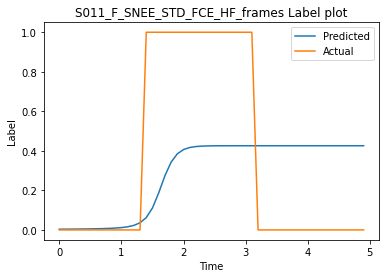

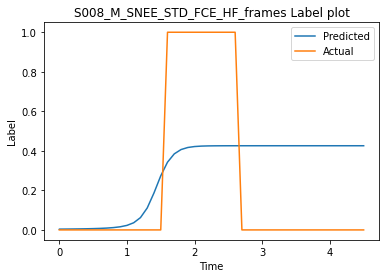

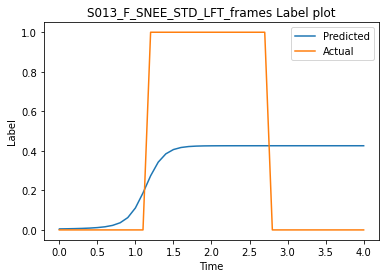

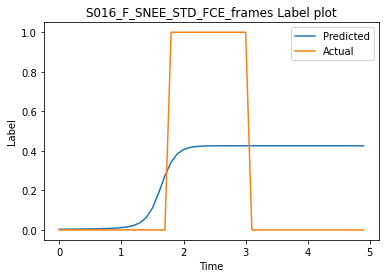

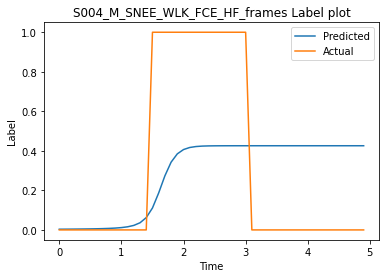

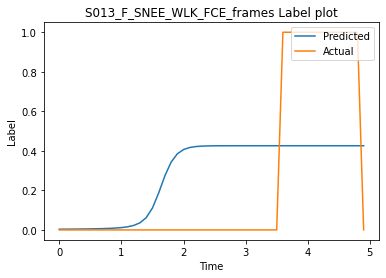

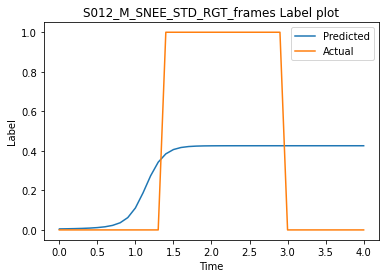

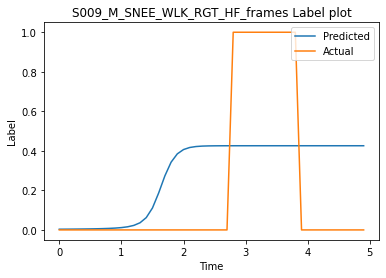

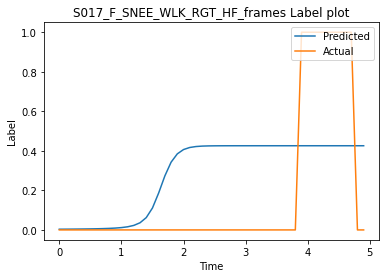

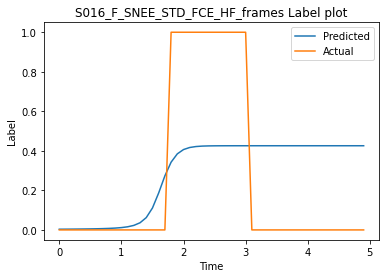

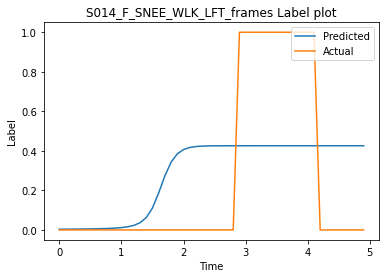

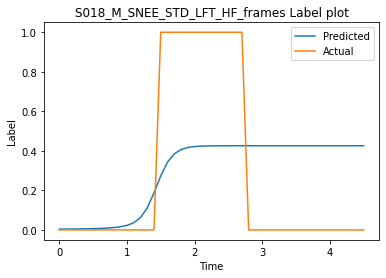

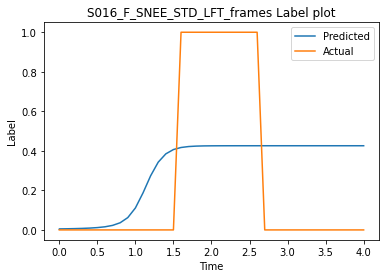

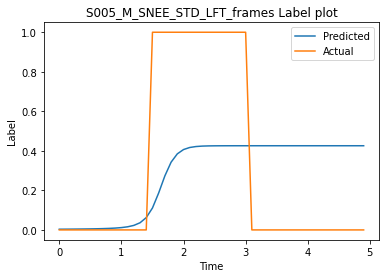

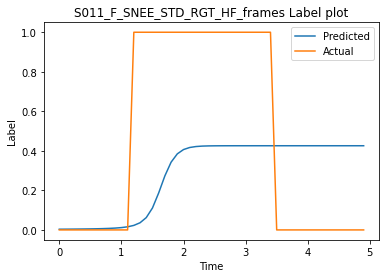

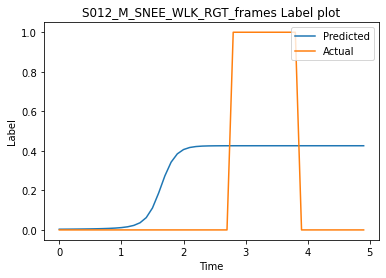

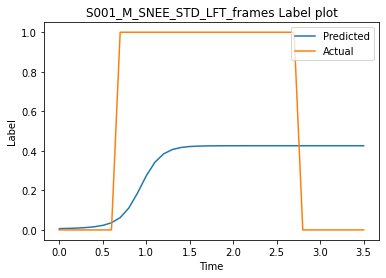

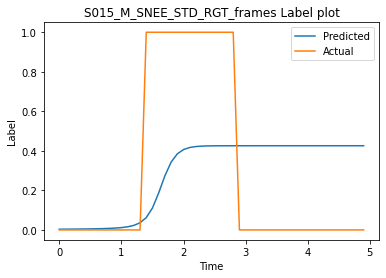

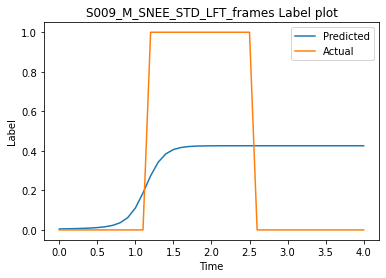

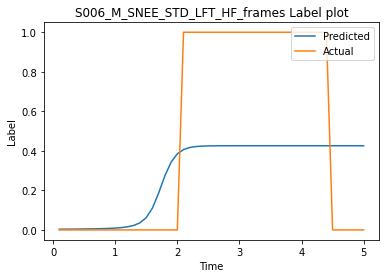

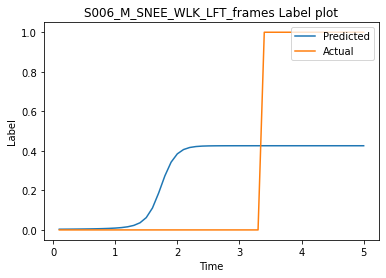

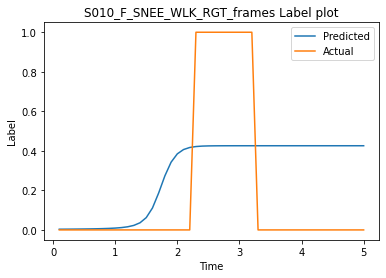

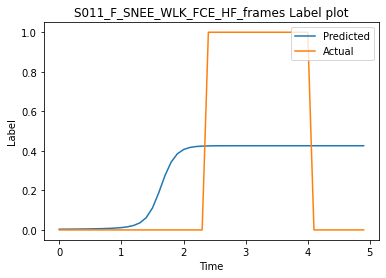

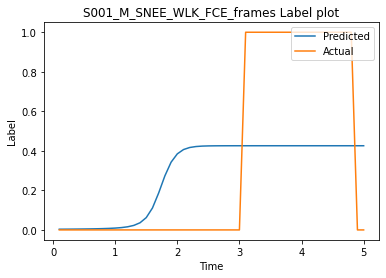

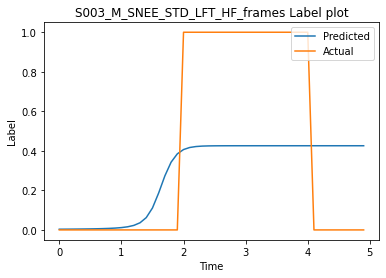

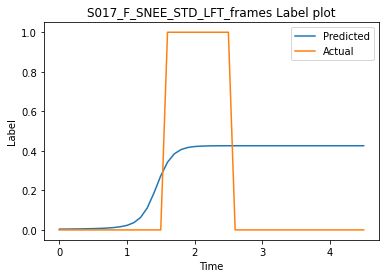

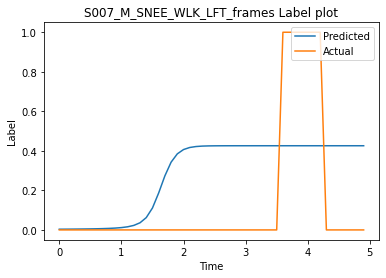

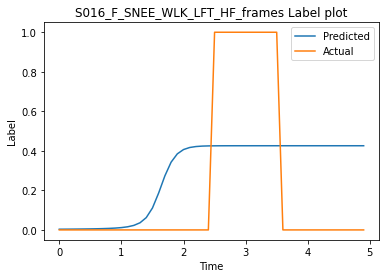

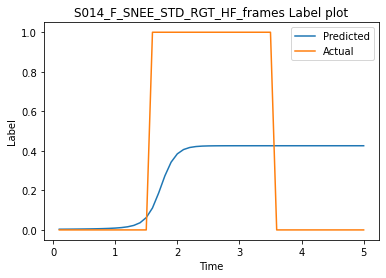

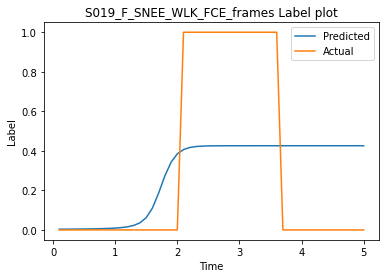

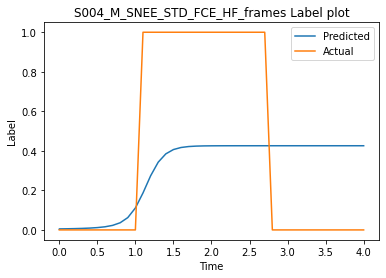

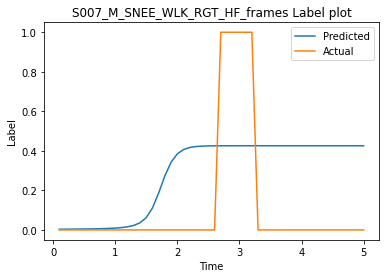

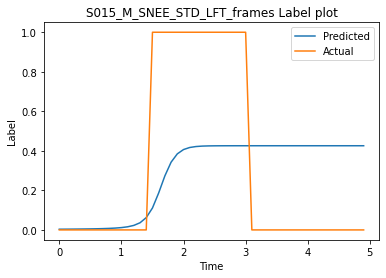

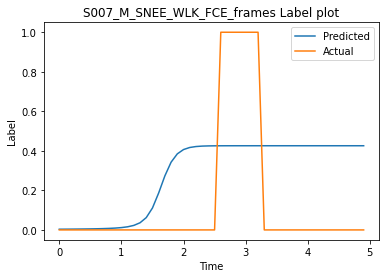

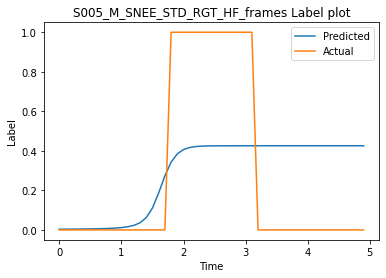

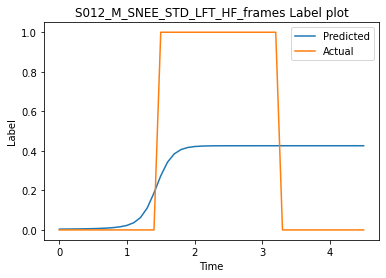

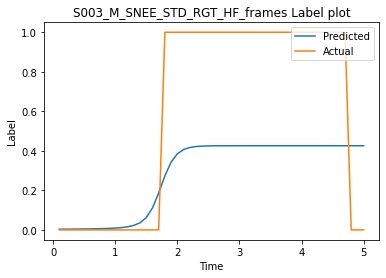

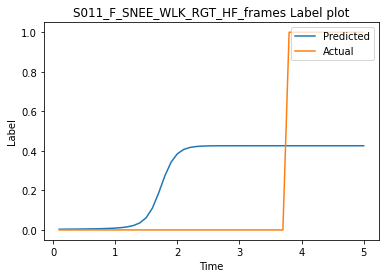

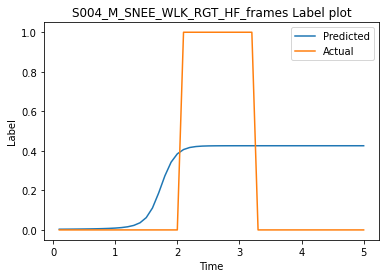

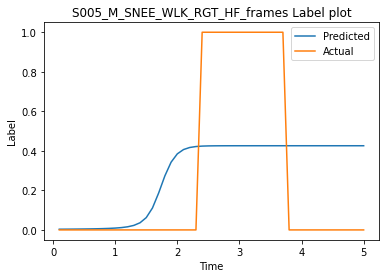

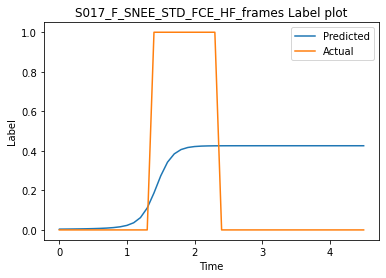

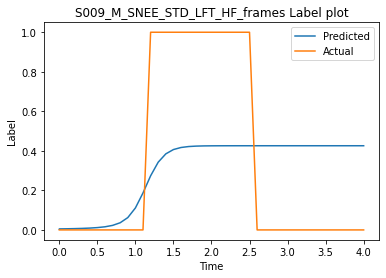

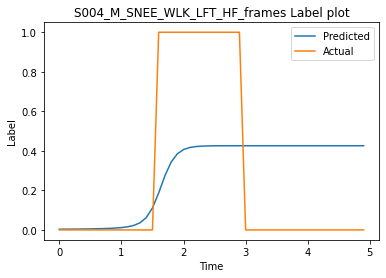

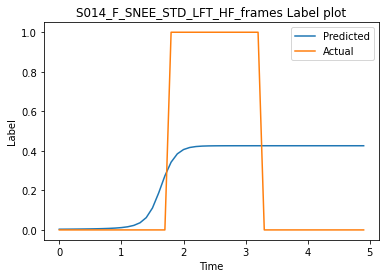

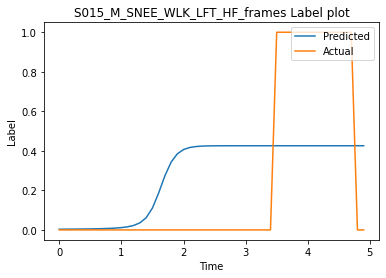

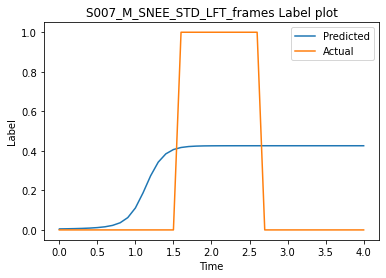

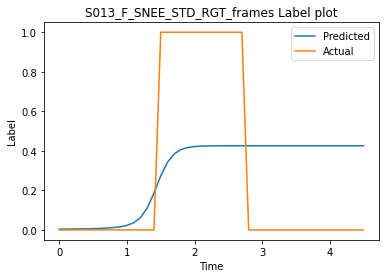

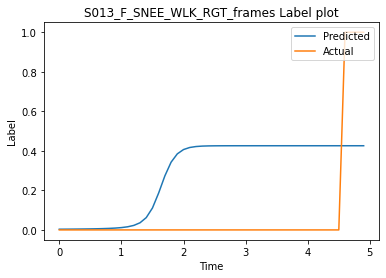

In [0]:
def get_times(y1,y2,vid,fps):
  frame_paths = os.listdir(frames_path + vid)
  n_f = len(frame_paths)
  df = df2
  labels = y1
  where_are_nans = np.isnan(labels)
  labels[where_are_nans] = 0
  labels = np.squeeze(labels)
  n_l = len(y2)
  t1 = np.arange(len(y1))/fps
  if n_l > n_f :
    diff = math.ceil((n_l-n_f)/2)
    output = [None]*n_l
    t = [None]*n_l
    # Repeating First element
    output[0:diff] = [labels[0]]*diff
    t[0:diff] = [t1[0]]*diff
    # Centering frames
    output[diff:diff + n_f] = labels[0:n_f]
    t[diff:diff + n_f] = t1[0:n_f]
    #Repeating last frames
    output[diff + n_f:] = [labels[n_f]]*(n_l-n_f-diff)
    output[diff + n_f:] = [labels[n_f]]*(n_l-n_f-diff)
  elif n_l < n_f:
    if sum(labels)>0:
      where_are_ones = np.isin(labels,1)
      idxs = np.nonzero(where_are_ones)
      idxs = np.squeeze(idxs)
      l = labels[where_are_ones]
      diff = math.ceil((n_l - len(l))/2)
      d1 = idxs[0] - diff
      d2 = idxs[-1]+diff
      if d1<0:
        idx = [0,n_l]
        output = labels[idx[0]:idx[1]]
        t = t1[idx[0]:idx[1]]
      elif d2>n_l:
        d1 = d1-d2+n_l
        idx = [d1,d1+n_l]
        output = labels[idx[0]:idx[1]]
        t = t1[idx[0]:idx[1]] 
      else:
        idx = [d1,d1+n_l]
        output = labels[idx[0]:idx[1]]
        t = t1[idx[0]:idx[1]]
        # print("D2-D1",d2-d1)
    else:
      diff = math.ceil((n_f-n_l)/2)
      idx = [diff,diff+n_l]
      output = labels[idx[0]:idx[1]]
      t = t1[idx[0]:idx[1]]
  else:
    output = labels[0:n_l]
    t = t1[0:n_l]
  output = np.expand_dims(output,axis=1)
  output1 = 1 - output
  output2 = np.concatenate([output,output1],axis=1) 
  t = np.squeeze(np.array(t))
  return t,output

tl = list()
tl2 = list()
y1_adj2 = list()
y_diff = list()
count = 0
for i,vid in enumerate(test_list):
  y1 = df2.loc[vid].values
  y2 = y_pred[i]
  t2,y1_adj = get_times(y1,y2,vid,10)
  y2x = y2[:,0]
  y1_adjx = y1_adj[:,0]
  plt.figure()
  plt.plot(t2,y2x)
  plt.plot(t2,y1_adjx)
  name = vid + ' Label plot' 
  plt.title(name)
  plt.ylabel('Label')
  plt.xlabel('Time')
  plt.legend(['Predicted', 'Actual'], loc='upper right')
  plt.savefig('drive/My Drive/Adv DL project/Label_figs2/'+vid+'.jpg')
  plt.close
  for j in range(len(y2)):
    tl += [t2[j],y2x[j]]
  tl2 += [tl]
  y3 = np.zeros(y2x.shape)
  y3_adj = np.zeros(y1_adjx.shape)
  y3[y2x>=0.5] = 1
  y3_adj[y1_adjx>=0.5] = 1 
  y_diff += [np.sum(np.abs(y3-y3_adj))/len(y3)]
  y1_adj2 += [y3_adj]
  if list(y3)==list(y3_adj) :
    count +=1
print(y_diff)
print(sum(y_diff)/len(test_list))
print(count*100/96)

In [0]:
d = []
for i,vid in enumerate(test_list):
  d.append({'heads_up': vid, 'timeLabels':tl2[i]})
tL_df = pd.DataFrame(d)
tL_df.to_json('drive/My Drive/Adv DL project/timeLabel1.json')

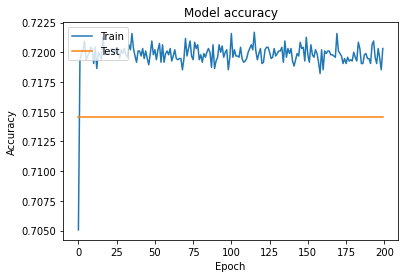

In [0]:
# Plot training & validation accuracy values
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()
plt.savefig('drive/My Drive/Adv DL project/Acc_vs_Epochs2.jpg')
# Plot training & validation loss values

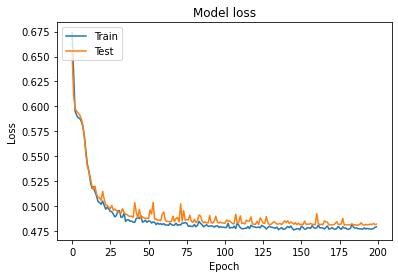

In [0]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()
plt.savefig('drive/My Drive/Adv DL project/Loss_vs_Epochs2.jpg')